In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.5 MB/s eta 0:00:00


In [ ]:
pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 88.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.5 MB/s eta 0:00:00


In [ ]:
!databricks configure --host https://community.cloud.databricks.com/

Username: kieuhuy2610@gmail.com
Password: 
Repeat for confirmation: 


In [ ]:
import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/kieuhuy2610@gmail.com/Fakenew")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/3503213961751883', creation_time=1702190009195, experiment_id='3503213961751883', last_update_time=1702209364602, lifecycle_stage='active', name='/Users/kieuhuy2610@gmail.com/Fakenew', tags={'mlflow.experiment.sourceName': '/Users/kieuhuy2610@gmail.com/Fakenew',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'kieuhuy2610@gmail.com',
 'mlflow.ownerId': '7531077540668616'}>

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
import torch.nn.functional as F
from torch import nn
from PIL import ImageColor
from torch_geometric.datasets import MNISTSuperpixels, UPFD
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, GATv2Conv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch.nn import Linear
from torch.optim import Adam
from torch.nn.modules.conv import Conv2d
from torch_geometric.data import DataLoader

from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix, f1_score,precision_score, recall_score

In [ ]:
train_data = UPFD(root=".", name="gossipcop", feature="content", split="train")
test_data = UPFD(root=".", name="gossipcop", feature="content", split="test")


Extracting ./gossipcop/raw/uc
Processing...
Done!


In [ ]:
print()
print(f'Dataset: {train_data}:')
print('======================')
print(f'Number of graphs: {len(train_data)}')
print(f'Number of features: {train_data.num_features}')
print(f'Number of classes: {train_data.num_classes}')


Dataset: UPFD(1092, name=gossipcop, feature=content):
Number of graphs: 1092
Number of features: 310
Number of classes: 2


In [ ]:
# General information in specific graph
data = train_data[3]
print(data)
print(f'Sample nodes:{train_data[3].num_nodes}')
print(f'Sample edges:{train_data[3].num_edges}')

Data(x=[56, 310], edge_index=[2, 0], y=[1])
Sample nodes:56
Sample edges:0


<Axes: >

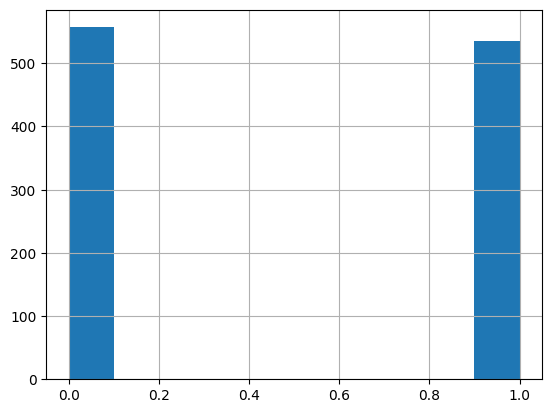

In [ ]:
import pandas as pd
labels = [data.y.item() for i, data in enumerate(train_data)]
df = pd.DataFrame(labels, columns=["Labels"])
df["Labels"].hist()

In [ ]:
device =(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.cuda.is_available()
    else "cpu"
)

In [ ]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
emb_size = 128
heads = 2
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()

        self.start_layer = GATv2Conv(train_data.num_features, emb_size, heads=heads, dropout=0.3)
        self.linear_start = Linear(emb_size * 2, emb_size)
        self.pool_start = TopKPooling(emb_size, ratio=0.8)

        self.gat2 = GATv2Conv(emb_size , emb_size, heads=heads, dropout=0.3)
        self.linear2 = Linear(emb_size * 2, emb_size)
        self.pool2 = TopKPooling(emb_size, ratio=0.6)

        self.gat3 = GATv2Conv(emb_size , emb_size, heads=heads, dropout=0.3)
        self.linear3 = Linear(emb_size * 2, emb_size)
        self.pool3 = TopKPooling(emb_size, ratio=0.4)

        self.gat4 = GATv2Conv(emb_size , emb_size, heads=heads, dropout=0.3)
        self.linear4 = Linear(emb_size * 2, emb_size)
        self.pool4 = TopKPooling(emb_size, ratio=0.2)

        self.dropout = torch.nn.Dropout(p=0.6)
        self.linear_final = Linear(emb_size * 2 , emb_size)
        self.out = Linear(emb_size, train_data.num_classes)

    def forward(self, x, edge_index, batch_index):
        h = self.start_layer(x, edge_index)
        h = F.relu(h)
        h = self.linear_start(h)
        h, edge_index, _, batch_index, _, _ = self.pool_start(h, edge_index, None, batch_index)
        h1 = torch.cat([gmp(h, batch_index), gap(h, batch_index)], dim=1)

        h = self.gat2(h, edge_index)
        h = F.relu(h)
        h = self.linear2(h)
        h, edge_index, _, batch_index, _, _ = self.pool2(h, edge_index, None, batch_index)
        h2 = torch.cat([gmp(h, batch_index), gap(h, batch_index)], dim=1)

        h = self.gat3(h, edge_index)
        h = F.relu(h)
        h = self.linear3(h)
        h, edge_index, _, batch_index, _, _ = self.pool3(h, edge_index, None, batch_index)
        h3 = torch.cat([gmp(h, batch_index), gap(h, batch_index)], dim=1)

        h = self.gat4(h, edge_index)
        h = F.relu(h)
        h = self.linear4(h)
        h, edge_index, _, batch_index, _, _ = self.pool4(h, edge_index, None, batch_index)
        h4 = torch.cat([gmp(h, batch_index), gap(h, batch_index)], dim=1)

        h = h1 + h2 + h3 + h4

        h_out = self.linear_final(h)
        h = self.dropout(h)
        out = self.out(h_out)

        return h,out

In [ ]:
model = GAT()
print(model)
print("Number of parameter:", sum(p.numel() for p in model.parameters()))

GAT(
  (start_layer): GATv2Conv(310, 128, heads=2)
  (linear_start): Linear(in_features=256, out_features=128, bias=True)
  (pool_start): TopKPooling(128, ratio=0.8, multiplier=1.0)
  (gat2): GATv2Conv(128, 128, heads=2)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (pool2): TopKPooling(128, ratio=0.6, multiplier=1.0)
  (gat3): GATv2Conv(128, 128, heads=2)
  (linear3): Linear(in_features=256, out_features=128, bias=True)
  (pool3): TopKPooling(128, ratio=0.4, multiplier=1.0)
  (gat4): GATv2Conv(128, 128, heads=2)
  (linear4): Linear(in_features=256, out_features=128, bias=True)
  (pool4): TopKPooling(128, ratio=0.2, multiplier=1.0)
  (dropout): Dropout(p=0.6, inplace=False)
  (linear_final): Linear(in_features=256, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=2, bias=True)
)
Number of parameter: 524674


In [ ]:
def plot_loss(loss_values):
    plt.plot(loss_values, label='Training Loss')
    plt.xlabel('Training Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

def calculate_metrics(y_pred, y_true, epoch, type):
    print(f"\n Confusion matrix: \n {confusion_matrix(y_pred, y_true)}")
    print(f"F1 Score: {f1_score(y_true, y_pred)}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")

    try:
        roc = roc_auc_score(y_true, y_pred)
        print(f"ROC AUC: {roc}")
    except:
        print(f"ROC AUC: notdefined")

def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader)
  model.train()
  best_loss = float("inf")
  step = 0
  running_loss = 0
  losses = []
  all_pred = []
  all_pred_raw = []
  all_labels = []
  for batch_idx, batch in enumerate(dataloader):
    batch = batch.to(device)
    optimizer.zero_grad()

    pred, embed = model(batch.x.float(), batch.edge_index, batch.batch)
    loss = loss_fn(pred, batch.y)

    loss.backward()
    optimizer.step()
  return loss,embed

def accuracy(pred_y, y):
  return((pred_y == y).sum()/len(y)).item()

def evaluate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loss = 0
    y_true = []
    y_pred_probs = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            pred, _ = model(batch.x.float(), batch.edge_index, batch.batch)
            test_loss += loss_fn(pred, batch.y).item()
            softmax_pred = F.softmax(pred, dim=1)  # Apply softmax to get probabilities
            y_true.extend(batch.y.tolist())
            y_pred_probs.extend(softmax_pred.tolist())

    test_loss /= size
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    accuracy = accuracy_score(y_true, np.argmax(y_pred_probs, axis=1))

    return test_loss, accuracy

In [ ]:
import mlflow.pytorch
from mlflow import MlflowClient
def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print(f"run_id: {r.info.run_id}")
    print(f"artifacts: {artifacts}")
    print(f"params: {r.data.params}")
    print(f"metrics: {r.data.metrics}")
    print(f"tags: {tags}")

In [ ]:

mlflow.pytorch.autolog()
with mlflow.start_run() as run:
  model = GAT().to(device)
  loss_fun = nn.CrossEntropyLoss()
  opt = Adam(model.parameters(), lr=0.001, weight_decay=5e-4)


  losses = []
  test_losses = []


  for epoch in range(40):
    print(f"Epoch {epoch+1}\n-------------------------------")
    loss, h = train(train_loader, model, loss_fun, opt)
    test_loss , correct = evaluate(test_loader, model, loss_fun)
    losses.append(loss)
    test_losses.append(test_loss)

    print("-------------------------------")
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))

Epoch 1
-------------------------------
-------------------------------
Test Error: 
 Accuracy: 50.1%, Avg loss: 0.028291 

Epoch 2
-------------------------------
-------------------------------
Test Error: 
 Accuracy: 50.1%, Avg loss: 0.029568 

Epoch 3
-------------------------------
-------------------------------
Test Error: 
 Accuracy: 49.9%, Avg loss: 0.029919 

Epoch 4
-------------------------------
-------------------------------
Test Error: 
 Accuracy: 50.1%, Avg loss: 0.029541 

Epoch 5
-------------------------------
-------------------------------
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.028936 

Epoch 6
-------------------------------
-------------------------------
Test Error: 
 Accuracy: 50.1%, Avg loss: 0.028481 

Epoch 7
-------------------------------
-------------------------------
Test Error: 
 Accuracy: 50.1%, Avg loss: 0.025637 

Epoch 8
-------------------------------
-------------------------------
Test Error: 
 Accuracy: 50.1%, Avg loss: 0.025282 

Epoch 9


IndexError: ignored